In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import AdaBoostClassifier,RandomForestClassifier
pd.set_option('use_inf_as_na', True)
from collections import Counter
import pickle

In [2]:
raw_data=pd.read_pickle(r'/Users/zhihongqiu/Downloads/Simon-Chicago/CHICAGO/Machine Learning/L3/dataset.pkl')

In [3]:
raw_data=pd.read_pickle(r'/Users/zhihongqiu/Downloads/Simon-Chicago/CHICAGO/Machine Learning/L3/dataset.pkl')

In [4]:
raw_data.head()

actq      apq        atq       ceqq      cheq  \
date       ticker                                                      
2000-02-01 LLB        3.540    0.143      7.668      6.732     2.553   
2000-02-03 MYR      107.661   24.387    220.463    136.555     1.049   
2000-02-08 LZB      447.719   57.893    740.905    460.612    16.531   
           SJM      234.415   33.821    488.136    322.432    26.054   
2000-02-09 CSCO    7722.000  482.000  21391.000  16523.000  3968.000   

                      cogsq     csh12q    cshfdq     cshiq  cshopq  ...  \
date       ticker                                                   ...   
2000-02-01 LLB        0.458     6.3910     6.391     6.989     0.0  ...   
2000-02-03 MYR       36.883    25.5360    22.082    28.458     0.0  ...   
2000-02-08 LZB      274.525    52.2660    52.274    52.544     0.0  ...   
           SJM       91.172    28.8808    28.603    32.425     0.0  ...   
2000-02-09 CSCO    1422.000  3374.1250  3648.000  3445.000     0.0  ...   

                   sector_code_815.0  sector_code_817.0  sector_code_822.0  \
date       ticker                                                            
2000-02-01 LLB                     0                  0                  0   
2000-02-03 MYR                     0                  0                  0   
2000-02-08 LZB                     0                  0                  0   
           SJM                     0                  0                  0   
2000-02-09 CSCO                    0                  0                  0   

                   sector_code_823.0  sector_code_825.0  sector_code_830.0  \
date       ticker                                                            
2000-02-01 LLB                     0                  0                  0   
2000-02-03 MYR                     0                  0                  0   
2000-02-08 LZB                     0                  0                  0   
           SJM                     0                  0                  0   
2000-02-09 CSCO                    0                  0                  0   

                   sector_code_835.0  sector_code_840.0  sector_code_845.0  \
date       ticker                                                            
2000-02-01 LLB                     0                  0                  0   
2000-02-03 MYR                     0                  0                  0   
2000-02-08 LZB                     0                  0                  0   
           SJM                     0                  0                  0   
2000-02-09 CSCO                    0                  0                  0   

                   sector_code_850.0  
date       ticker                     
2000-02-01 LLB                     0  
2000-02-03 MYR                     0  
2000-02-08 LZB                     0  
           SJM                     0  
2000-02-09 CSCO                    0  

[5 rows x 731 columns]

In [5]:
data = raw_data[raw_data['market_cap'] > 1000.0]
data = data.copy()
data.fillna(0.0,inplace=True)

In [6]:
#label function
def f(x):
    if x > 0.01:
        return 1
    elif x < -0.025:
        return -1
    else:
    
        return 0

In [7]:
data['rel_performance'] = data['pred_rel_return'].apply(f)
data.reset_index(inplace=True)
data.set_index('date',inplace=True)

In [8]:
from sklearn.preprocessing import MinMaxScaler,StandardScaler
scaler = StandardScaler()

In [9]:
start_dates = [pd.to_datetime('2001-01-01') + pd.DateOffset(months = 3*i) for i in range(57)]
end_dates = [d + pd.DateOffset(months = 36) for d in start_dates]

In [10]:
training_frames = [data.loc[d:d+pd.DateOffset(months = 36)] for d in start_dates]
valid_frames = [data.loc[d+pd.DateOffset(months = 3):d+pd.DateOffset(months = 6)] for d in end_dates]
test_frames = [data.loc[d+pd.DateOffset(months = 9):d+pd.DateOffset(months = 12)] for d in end_dates]

In [11]:
training_data = [d.reset_index().drop
                 (['ticker', 'date',
                   'next_period_return',
                   'spy_next_period_return',
                   'rel_performance', 'pred_rel_return',
                   'return', 'cum_ret', 'spy_cum_ret'], axis=1) for d in training_frames]
valid_data = [d.reset_index().drop
              (['ticker', 'date',
                'next_period_return',
                'spy_next_period_return',
                'rel_performance', 'pred_rel_return',
                'return', 'cum_ret', 'spy_cum_ret'], axis=1) for d in valid_frames]
test_data = [d.reset_index().drop(['ticker', 'date',
                                   'next_period_return',
                                   'spy_next_period_return',
                                   'rel_performance', 'pred_rel_return',
                                   'return', 'cum_ret', 'spy_cum_ret'], axis=1) for d in test_frames]

In [12]:
training_labels = [d['rel_performance'].values for d in training_frames]
valid_labels = [d['rel_performance'].values for d in valid_frames] 

In [13]:
for i in range(len(start_dates)-1):
    float_vars = [x for x in training_data[i].columns if data[x].dtype == 'float64']

    scaler = StandardScaler()
    training_data[i] = training_data[i].copy()
    valid_data[i] = valid_data[i].copy()
    test_data[i] = test_data[i].copy()
    training_data[i][float_vars] = scaler.fit_transform(training_data[i][float_vars])
    valid_data[i][float_vars] = scaler.transform(valid_data[i][float_vars])
    test_data[i][float_vars] = scaler.transform(test_data[i][float_vars])
        
    

In [14]:
import optuna
from optuna.trial import Trial
optuna.logging.set_verbosity(optuna.logging.FATAL)
import warnings
warnings.filterwarnings("ignore")

In [68]:
def calculate_max_drawdown(returns):
    peak = returns.max()
    drawdown = (returns - peak) / peak
    max_drawdown = drawdown.min()
    return max_drawdown

In [15]:
def max_drawdown(returns):
        local_max = [n for n in range(len(returns)-1) if ((n==0) and (returns[0] > returns[1])) or 
           ((n > 0) and  (returns[n-1]<returns[n]) and (returns[n+1]<returns[n]))] 
        
        local_min = [n for n in range(1,len(returns)) if ((n == len(returns)-1) and (returns[-1] < returns[-2])) or
                (returns[n-1]>returns[n]) and (returns[n+1]>returns[n])]
        
        def next_local_min(n):
            if [m for m in local_min if m > n]:
                return [m for m in local_min if m > n][0]
            else: return None
        
        drawdowns = [(n,next_local_min(n)) for n in local_max]
        drawdown_values = [returns[n] - returns[m] for (n,m) in drawdowns if m != None]
        if drawdown_values:
            return  np.max(drawdown_values)
        else: return 0.0

In [65]:
def objective_mdd(trial:Trial,train=None,labels=None,val=None,val_labels=None,val_rets=None):

    ada_m_depth = trial.suggest_int('max_depth',1,2,step=1)
    ada_n_estimators = trial.suggest_int('n_estimators', 10,100,step=10)
    ada_learning_rate = trial.suggest_float('learning_rate',0.1,0.5, step=0.1)

    
    ada_clf = AdaBoostClassifier(DecisionTreeClassifier(max_depth=ada_m_depth),
                                 n_estimators=ada_n_estimators,
                                 learning_rate=ada_learning_rate,
                                 algorithm="SAMME.R")

    ada_clf.fit(train,labels)
    preds = ada_clf.predict(val)
    mdd = max_drawdown(preds*val_rets.values)
 
    return mdd


In [17]:
def objective(trial:Trial,train=None,labels=None,val=None,val_labels=None,val_rets=None):

    ada_m_depth = trial.suggest_int('max_depth',1,3,step=1)
    ada_n_estimators = trial.suggest_int('n_estimators', 10,100,step=10)
    ada_learning_rate = trial.suggest_float('learning_rate',0.1,0.5, step=0.1)

    
    ada_clf = AdaBoostClassifier(DecisionTreeClassifier(max_depth=ada_m_depth),
                                 n_estimators=ada_n_estimators,
                                 learning_rate=ada_learning_rate,
                                 algorithm="SAMME.R")

    ada_clf.fit(train,labels)
    preds = ada_clf.predict(val)
    accuracy = ada_clf.score(val,val_labels)
 
    return accuracy


***Accuracy Object***

In [31]:
optimal_hyperparameters = []

In [32]:
from functools import partial

In [33]:
for i in range(len(start_dates)-1):

    study = optuna.create_study(direction="maximize")

    study.optimize(partial(objective,
                           train=training_data[i],
                           labels=training_labels[i],
                           val=valid_data[i],
                           val_labels=valid_labels[i],
                           val_rets=valid_frames[i]['next_period_return']), n_trials=25,n_jobs=-1)

    optimal_hyperparameters.append(study.best_params)  
    print(study.best_params)


{'max_depth': 2, 'n_estimators': 100, 'learning_rate': 0.5}
{'max_depth': 1, 'n_estimators': 30, 'learning_rate': 0.1}
{'max_depth': 3, 'n_estimators': 10, 'learning_rate': 0.2}
{'max_depth': 2, 'n_estimators': 60, 'learning_rate': 0.4}
{'max_depth': 1, 'n_estimators': 10, 'learning_rate': 0.1}
{'max_depth': 3, 'n_estimators': 90, 'learning_rate': 0.4}
{'max_depth': 1, 'n_estimators': 10, 'learning_rate': 0.2}
{'max_depth': 1, 'n_estimators': 50, 'learning_rate': 0.30000000000000004}
{'max_depth': 3, 'n_estimators': 50, 'learning_rate': 0.4}
{'max_depth': 2, 'n_estimators': 20, 'learning_rate': 0.5}
{'max_depth': 3, 'n_estimators': 70, 'learning_rate': 0.1}
{'max_depth': 2, 'n_estimators': 70, 'learning_rate': 0.5}
{'max_depth': 3, 'n_estimators': 80, 'learning_rate': 0.5}
{'max_depth': 2, 'n_estimators': 70, 'learning_rate': 0.30000000000000004}
{'max_depth': 3, 'n_estimators': 70, 'learning_rate': 0.30000000000000004}
{'max_depth': 1, 'n_estimators': 70, 'learning_rate': 0.5}
{'max_d

In [34]:
import _pickle as cPickle

In [35]:
with open(r'optimal_hyperparameters_ada_01.pkl','wb') as f:
    pickle.dump(optimal_hyperparameters,f)

In [36]:
with open(r'optimal_hyperparameters_ada_01.pkl','rb') as f:
    optimal_hyperparameters = cPickle.load(f)

In [37]:
optimal_hyperparameters

[{'max_depth': 2, 'n_estimators': 100, 'learning_rate': 0.5},
 {'max_depth': 1, 'n_estimators': 30, 'learning_rate': 0.1},
 {'max_depth': 3, 'n_estimators': 10, 'learning_rate': 0.2},
 {'max_depth': 2, 'n_estimators': 60, 'learning_rate': 0.4},
 {'max_depth': 1, 'n_estimators': 10, 'learning_rate': 0.1},
 {'max_depth': 3, 'n_estimators': 90, 'learning_rate': 0.4},
 {'max_depth': 1, 'n_estimators': 10, 'learning_rate': 0.2},
 {'max_depth': 1, 'n_estimators': 50, 'learning_rate': 0.30000000000000004},
 {'max_depth': 3, 'n_estimators': 50, 'learning_rate': 0.4},
 {'max_depth': 2, 'n_estimators': 20, 'learning_rate': 0.5},
 {'max_depth': 3, 'n_estimators': 70, 'learning_rate': 0.1},
 {'max_depth': 2, 'n_estimators': 70, 'learning_rate': 0.5},
 {'max_depth': 3, 'n_estimators': 80, 'learning_rate': 0.5},
 {'max_depth': 2, 'n_estimators': 70, 'learning_rate': 0.30000000000000004},
 {'max_depth': 3, 'n_estimators': 70, 'learning_rate': 0.30000000000000004},
 {'max_depth': 1, 'n_estimators': 70

In [38]:
classifiers = []

In [39]:
for hyp_par in optimal_hyperparameters:
    max_depth = hyp_par['max_depth']
    n_estimators = hyp_par['n_estimators']
    learning_rate = hyp_par['learning_rate']
    ada_clf = AdaBoostClassifier(DecisionTreeClassifier(max_depth=max_depth),n_estimators=n_estimators,learning_rate=learning_rate)
    classifiers.append(ada_clf)

In [40]:
for i in range(len(start_dates)-1): 
    classifiers[i].fit(training_data[i],training_labels[i])

In [41]:
with open(r'classifiers_ada_01.pkl','wb') as f:
    cPickle.dump(classifiers,f)

In [42]:
with open(r'classifiers_ada_01.pkl','rb') as f:
    classifiers = cPickle.load(f)

In [43]:
def adaboost_feat_importances(m, df):
        
    return pd.DataFrame({'cols':df.columns, 'feat_imp': m.feature_importances_}
                       ).sort_values('feat_imp', ascending=False)

First feature

In [44]:
with open(r'/Users/zhihongqiu/Downloads/Simon-Chicago/CHICAGO/Machine Learning/L10/Lecture_1___Feb__8_____4_export/Data for HW 3/shap_features_ada.pkl','rb') as f:
    shap_features = cPickle.load(f)

In [45]:
scalers = [StandardScaler() for i in range(len(start_dates)-1)]
           
opt_training_data = [pd.DataFrame(scalers[i].fit_transform(training_frames[i][shap_features[i]].values),columns=shap_features[i]) for i in range(len(start_dates)-1)]
opt_valid_data = [pd.DataFrame(scalers[i].fit_transform(training_frames[i][shap_features[i]].values),columns=shap_features[i]) for i in range(len(start_dates)-1)]
opt_test_data = [pd.DataFrame(scalers[i].transform(test_frames[i][shap_features[i]].values),columns=shap_features[i]) for i in range(len(start_dates)-1)]

In [46]:
x = [1]
ret = []

for i in range(len(start_dates)-1):
        
        classifiers[i].fit(opt_training_data[i],training_labels[i])

        preds = classifiers[i].predict(opt_test_data[i])
        profit_i = (preds*test_frames[i]['next_period_return']).sum()
        ret.append(profit_i)
        num_names = len(opt_test_data[i])
        x.append(x[i] + (x[i]/num_names)*profit_i)

In [49]:
SPY = pd.read_pickle(r'/Users/zhihongqiu/Downloads/Simon-Chicago/CHICAGO/Machine Learning/L2/SPY_cum_ret.pkl')
SPY = SPY.loc['2004-09-01':'2018-09-30']
SPY = SPY.resample('Q').ffill()
SPY['spy_cum_ret'] = (SPY['spy_cum_ret'] - SPY['spy_cum_ret'][0] + 1)
SPY['strategy'] = x

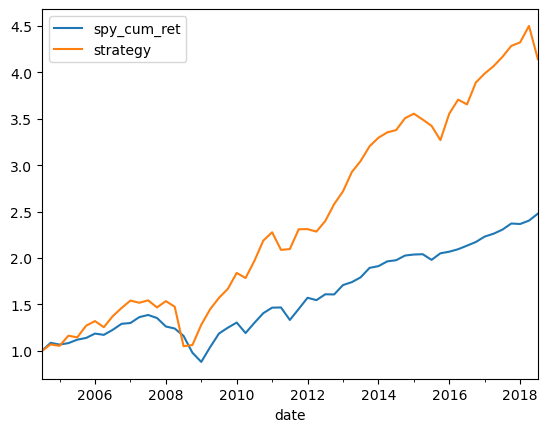

In [50]:
SPY.plot();

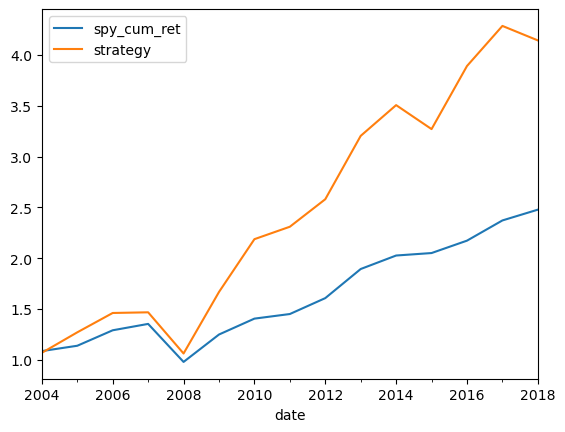

In [51]:
SPY = SPY.resample('Y').ffill()
SPY.plot();

Strategy Sharpe Ratio:  0.6719619687784364


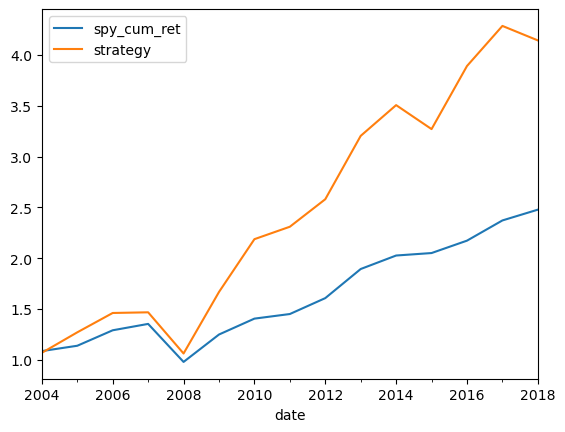

In [52]:
SPY.plot();
strategy_mean_ret = (SPY['strategy'] - 1).diff().mean()
strategy_std = (SPY['strategy'] - 1).diff().std()
strategy_sr = strategy_mean_ret / strategy_std
print('Strategy Sharpe Ratio: ', strategy_sr)

In [69]:
calculate_max_drawdown(SPY['strategy'])

-0.7634056244351538


Second Feature

In [53]:
with open(r'/Users/zhihongqiu/Downloads/Simon-Chicago/CHICAGO/Machine Learning/L10/Lecture_1___Feb__8_____4_export/Data for HW 3/shap_features_ada_01.pkl','rb') as f:
    shap_features = cPickle.load(f)

In [54]:
scalers = [StandardScaler() for i in range(len(start_dates)-1)]
           
opt_training_data = [pd.DataFrame(scalers[i].fit_transform(training_frames[i][shap_features[i]].values),columns=shap_features[i]) for i in range(len(start_dates)-1)]
opt_valid_data = [pd.DataFrame(scalers[i].fit_transform(training_frames[i][shap_features[i]].values),columns=shap_features[i]) for i in range(len(start_dates)-1)]
opt_test_data = [pd.DataFrame(scalers[i].transform(test_frames[i][shap_features[i]].values),columns=shap_features[i]) for i in range(len(start_dates)-1)]

In [55]:
x = [1]
ret = []

for i in range(len(start_dates)-1):
        
        classifiers[i].fit(opt_training_data[i],training_labels[i])

        preds = classifiers[i].predict(opt_test_data[i])
        profit_i = (preds*test_frames[i]['next_period_return']).sum()
        ret.append(profit_i)
        num_names = len(opt_test_data[i])
        x.append(x[i] + (x[i]/num_names)*profit_i)

In [57]:
SPY = pd.read_pickle(r'/Users/zhihongqiu/Downloads/Simon-Chicago/CHICAGO/Machine Learning/L2/SPY_cum_ret.pkl')
SPY = SPY.loc['2004-09-01':'2018-09-30']
SPY = SPY.resample('Q').ffill()
SPY['spy_cum_ret'] = (SPY['spy_cum_ret'] - SPY['spy_cum_ret'][0] + 1)
SPY['strategy'] = x

Strategy Sharpe Ratio:  0.4348686133132092


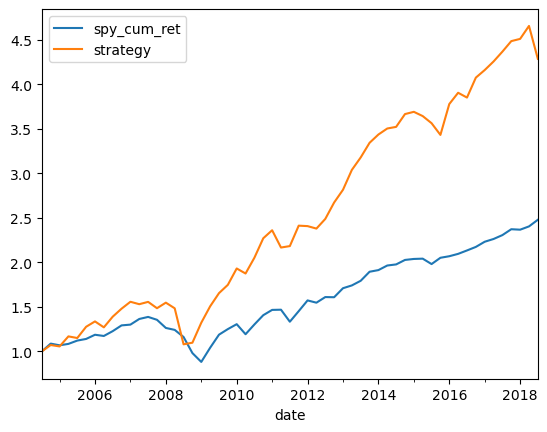

In [58]:
SPY.plot();
strategy_mean_ret = (SPY['strategy'] - 1).diff().mean()
strategy_std = (SPY['strategy'] - 1).diff().std()
strategy_sr = strategy_mean_ret / strategy_std
print('Strategy Sharpe Ratio: ', strategy_sr)

In [70]:
calculate_max_drawdown(SPY['strategy'])

-0.7575373260093302


Third Feature

In [59]:
with open(r'/Users/zhihongqiu/Downloads/Simon-Chicago/CHICAGO/Machine Learning/L10/Lecture_1___Feb__8_____4_export/Data for HW 3/shap_features_ada_02.pkl','rb') as f:
    shap_features = cPickle.load(f)

In [61]:
scalers = [StandardScaler() for i in range(len(start_dates)-1)]
           
opt_training_data = [pd.DataFrame(scalers[i].fit_transform(training_frames[i][shap_features[i]].values),columns=shap_features[i]) for i in range(len(start_dates)-1)]
opt_valid_data = [pd.DataFrame(scalers[i].fit_transform(training_frames[i][shap_features[i]].values),columns=shap_features[i]) for i in range(len(start_dates)-1)]
opt_test_data = [pd.DataFrame(scalers[i].transform(test_frames[i][shap_features[i]].values),columns=shap_features[i]) for i in range(len(start_dates)-1)]

In [62]:
x = [1]
ret = []

for i in range(len(start_dates)-1):
        
        classifiers[i].fit(opt_training_data[i],training_labels[i])

        preds = classifiers[i].predict(opt_test_data[i])
        profit_i = (preds*test_frames[i]['next_period_return']).sum()
        ret.append(profit_i)
        num_names = len(opt_test_data[i])
        x.append(x[i] + (x[i]/num_names)*profit_i)

In [63]:
SPY = pd.read_pickle(r'/Users/zhihongqiu/Downloads/Simon-Chicago/CHICAGO/Machine Learning/L2/SPY_cum_ret.pkl')
SPY = SPY.loc['2004-09-01':'2018-09-30']
SPY = SPY.resample('Q').ffill()
SPY['spy_cum_ret'] = (SPY['spy_cum_ret'] - SPY['spy_cum_ret'][0] + 1)
SPY['strategy'] = x

Strategy Sharpe Ratio:  0.3961773274977296


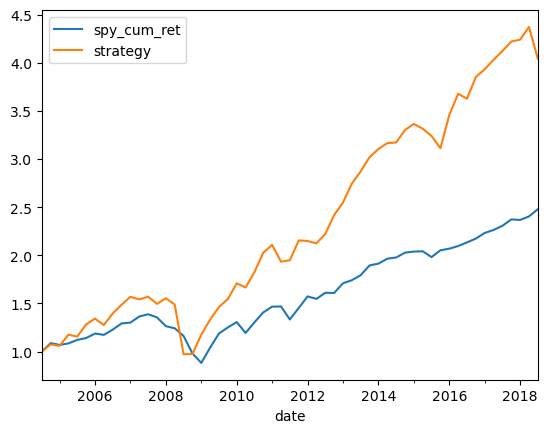

In [64]:
SPY.plot();
strategy_mean_ret = (SPY['strategy'] - 1).diff().mean()
strategy_std = (SPY['strategy'] - 1).diff().std()
strategy_sr = strategy_mean_ret / strategy_std
print('Strategy Sharpe Ratio: ', strategy_sr)

In [71]:
calculate_max_drawdown(SPY['strategy'])

-0.765093963351487


***MDD Object***

In [67]:
optimal_hyperparameters = []
from functools import partial

for i in range(len(start_dates) - 1):
    study = optuna.create_study(direction="minimize")

    study.optimize(partial(objective_mdd,
                           train=training_data[i],
                           labels=training_labels[i],
                           val=valid_data[i],
                           val_labels=valid_labels[i],
                           val_rets=valid_frames[i]['next_period_return']), n_trials=25, n_jobs=-1)

    optimal_hyperparameters.append(study.best_params)
    print(study.best_params)


{'max_depth': 1, 'n_estimators': 10, 'learning_rate': 0.4}
{'max_depth': 2, 'n_estimators': 60, 'learning_rate': 0.1}
{'max_depth': 1, 'n_estimators': 10, 'learning_rate': 0.1}
{'max_depth': 2, 'n_estimators': 10, 'learning_rate': 0.2}
{'max_depth': 1, 'n_estimators': 10, 'learning_rate': 0.4}
{'max_depth': 2, 'n_estimators': 10, 'learning_rate': 0.30000000000000004}
{'max_depth': 1, 'n_estimators': 20, 'learning_rate': 0.4}
{'max_depth': 1, 'n_estimators': 20, 'learning_rate': 0.2}
{'max_depth': 1, 'n_estimators': 10, 'learning_rate': 0.4}
{'max_depth': 2, 'n_estimators': 20, 'learning_rate': 0.5}
{'max_depth': 1, 'n_estimators': 10, 'learning_rate': 0.30000000000000004}
{'max_depth': 1, 'n_estimators': 20, 'learning_rate': 0.30000000000000004}
{'max_depth': 2, 'n_estimators': 100, 'learning_rate': 0.4}
{'max_depth': 2, 'n_estimators': 20, 'learning_rate': 0.30000000000000004}
{'max_depth': 1, 'n_estimators': 20, 'learning_rate': 0.30000000000000004}
{'max_depth': 2, 'n_estimators': 9

In [72]:
classifiers = []
for hyp_par in optimal_hyperparameters:
    max_depth = hyp_par['max_depth']
    n_estimators = hyp_par['n_estimators']
    learning_rate = hyp_par['learning_rate']
    ada_clf = AdaBoostClassifier(DecisionTreeClassifier(max_depth=max_depth), n_estimators=n_estimators,
                                 learning_rate=learning_rate)
    classifiers.append(ada_clf)
for i in range(len(start_dates) - 1):
    classifiers[i].fit(training_data[i], training_labels[i])
with open(r'classifiers_ada_01.pkl', 'wb') as f:
    cPickle.dump(classifiers, f)
with open(r'classifiers_ada_01.pkl', 'rb') as f:
    classifiers = cPickle.load(f)


def adaboost_feat_importances(m, df):
    return pd.DataFrame({'cols': df.columns, 'feat_imp': m.feature_importances_}
                        ).sort_values('feat_imp', ascending=False)

First Feature

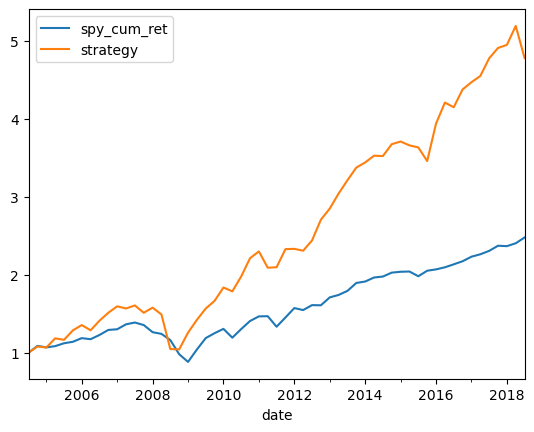

In [73]:
with open(
        r'/Users/zhihongqiu/Downloads/Simon-Chicago/CHICAGO/Machine Learning/L10/Lecture_1___Feb__8_____4_export/Data for HW 3/shap_features_ada.pkl',
        'rb') as f:
    shap_features = cPickle.load(f)
scalers = [StandardScaler() for i in range(len(start_dates) - 1)]

opt_training_data = [
    pd.DataFrame(scalers[i].fit_transform(training_frames[i][shap_features[i]].values), columns=shap_features[i]) for i
    in range(len(start_dates) - 1)]
opt_valid_data = [
    pd.DataFrame(scalers[i].fit_transform(training_frames[i][shap_features[i]].values), columns=shap_features[i]) for i
    in range(len(start_dates) - 1)]
opt_test_data = [pd.DataFrame(scalers[i].transform(test_frames[i][shap_features[i]].values), columns=shap_features[i])
                 for i in range(len(start_dates) - 1)]
x = [1]
ret = []

for i in range(len(start_dates) - 1):
    classifiers[i].fit(opt_training_data[i], training_labels[i])

    preds = classifiers[i].predict(opt_test_data[i])
    profit_i = (preds * test_frames[i]['next_period_return']).sum()
    ret.append(profit_i)
    num_names = len(opt_test_data[i])
    x.append(x[i] + (x[i] / num_names) * profit_i)
SPY = pd.read_pickle(r'/Users/zhihongqiu/Downloads/Simon-Chicago/CHICAGO/Machine Learning/L2/SPY_cum_ret.pkl')
SPY = SPY.loc['2004-09-01':'2018-09-30']
SPY = SPY.resample('Q').ffill()
SPY['spy_cum_ret'] = (SPY['spy_cum_ret'] - SPY['spy_cum_ret'][0] + 1)
SPY['strategy'] = x
SPY.plot();

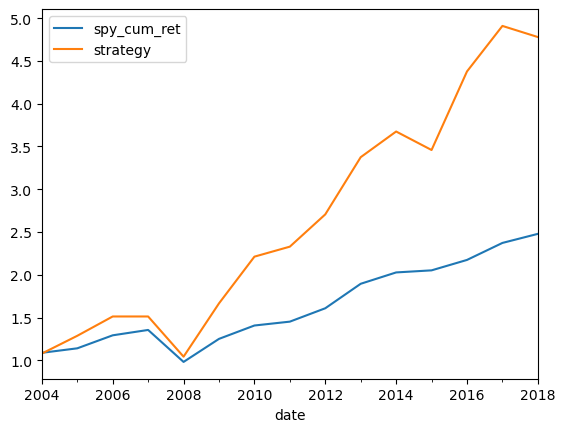

In [74]:
SPY = SPY.resample('Y').ffill()
SPY.plot();

Strategy Sharpe Ratio:  0.6900089718743945


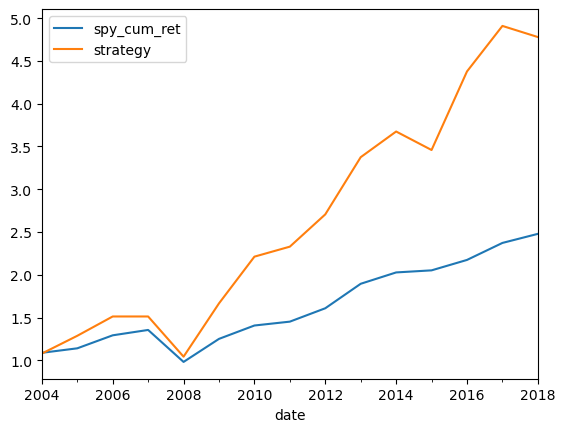

In [75]:
SPY.plot();
strategy_mean_ret = (SPY['strategy'] - 1).diff().mean()
strategy_std = (SPY['strategy'] - 1).diff().std()
strategy_sr = strategy_mean_ret / strategy_std
print('Strategy Sharpe Ratio: ', strategy_sr)

In [76]:
calculate_max_drawdown(SPY['strategy'])

-0.787708557384395

Second Feature

Strategy Sharpe Ratio:  0.43566538390297993


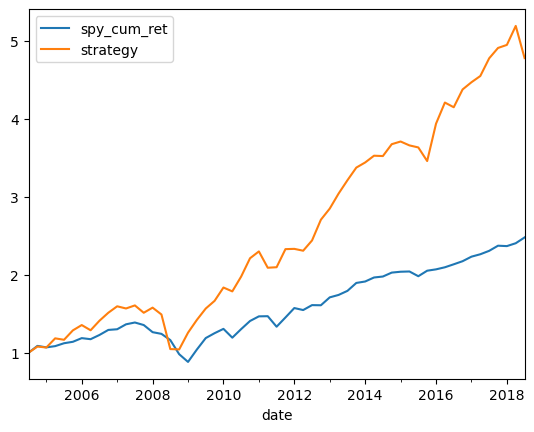

In [77]:
scalers = [StandardScaler() for i in range(len(start_dates) - 1)]

opt_training_data = [
    pd.DataFrame(scalers[i].fit_transform(training_frames[i][shap_features[i]].values), columns=shap_features[i]) for i
    in range(len(start_dates) - 1)]
opt_valid_data = [
    pd.DataFrame(scalers[i].fit_transform(training_frames[i][shap_features[i]].values), columns=shap_features[i]) for i
    in range(len(start_dates) - 1)]
opt_test_data = [pd.DataFrame(scalers[i].transform(test_frames[i][shap_features[i]].values), columns=shap_features[i])
                 for i in range(len(start_dates) - 1)]
x = [1]
ret = []

for i in range(len(start_dates) - 1):
    classifiers[i].fit(opt_training_data[i], training_labels[i])

    preds = classifiers[i].predict(opt_test_data[i])
    profit_i = (preds * test_frames[i]['next_period_return']).sum()
    ret.append(profit_i)
    num_names = len(opt_test_data[i])
    x.append(x[i] + (x[i] / num_names) * profit_i)
SPY = pd.read_pickle(r'/Users/zhihongqiu/Downloads/Simon-Chicago/CHICAGO/Machine Learning/L2/SPY_cum_ret.pkl')
SPY = SPY.loc['2004-09-01':'2018-09-30']
SPY = SPY.resample('Q').ffill()
SPY['spy_cum_ret'] = (SPY['spy_cum_ret'] - SPY['spy_cum_ret'][0] + 1)
SPY['strategy'] = x
SPY.plot();
strategy_mean_ret = (SPY['strategy'] - 1).diff().mean()
strategy_std = (SPY['strategy'] - 1).diff().std()
strategy_sr = strategy_mean_ret / strategy_std
print('Strategy Sharpe Ratio: ', strategy_sr)

In [78]:
calculate_max_drawdown(SPY['strategy'])

-0.8073218021346187

Third Feature

Strategy Sharpe Ratio:  0.41989233674168547


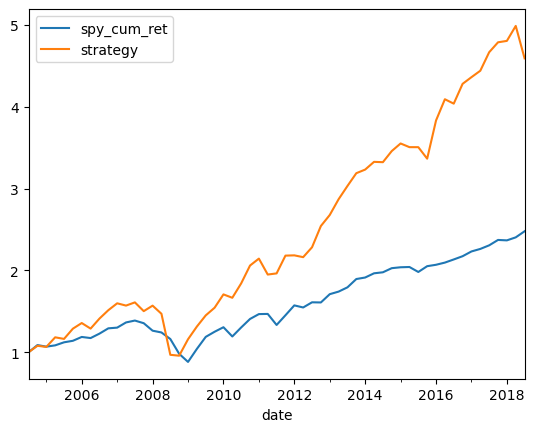

In [79]:
with open(
        r'/Users/zhihongqiu/Downloads/Simon-Chicago/CHICAGO/Machine Learning/L10/Lecture_1___Feb__8_____4_export/Data for HW 3/shap_features_ada_02.pkl',
        'rb') as f:
    shap_features = cPickle.load(f)
scalers = [StandardScaler() for i in range(len(start_dates) - 1)]

opt_training_data = [
    pd.DataFrame(scalers[i].fit_transform(training_frames[i][shap_features[i]].values), columns=shap_features[i]) for i
    in range(len(start_dates) - 1)]
opt_valid_data = [
    pd.DataFrame(scalers[i].fit_transform(training_frames[i][shap_features[i]].values), columns=shap_features[i]) for i
    in range(len(start_dates) - 1)]
opt_test_data = [pd.DataFrame(scalers[i].transform(test_frames[i][shap_features[i]].values), columns=shap_features[i])
                 for i in range(len(start_dates) - 1)]
x = [1]
ret = []

for i in range(len(start_dates) - 1):
    classifiers[i].fit(opt_training_data[i], training_labels[i])

    preds = classifiers[i].predict(opt_test_data[i])
    profit_i = (preds * test_frames[i]['next_period_return']).sum()
    ret.append(profit_i)
    num_names = len(opt_test_data[i])
    x.append(x[i] + (x[i] / num_names) * profit_i)
SPY = pd.read_pickle(r'/Users/zhihongqiu/Downloads/Simon-Chicago/CHICAGO/Machine Learning/L2/SPY_cum_ret.pkl')
SPY = SPY.loc['2004-09-01':'2018-09-30']
SPY = SPY.resample('Q').ffill()
SPY['spy_cum_ret'] = (SPY['spy_cum_ret'] - SPY['spy_cum_ret'][0] + 1)
SPY['strategy'] = x
SPY.plot();
strategy_mean_ret = (SPY['strategy'] - 1).diff().mean()
strategy_std = (SPY['strategy'] - 1).diff().std()
strategy_sr = strategy_mean_ret / strategy_std
print('Strategy Sharpe Ratio: ', strategy_sr)

In [80]:
calculate_max_drawdown(SPY['strategy'])

-0.8079293529157426

***Function F Modification***

In [121]:
#label function
def g(x):
    if x > 0.01:
        return 1
    elif x < -0.025:
        return -2
    elif x < -0.1:
        return -1
    else:    
        return 0

In [122]:
data['rel_performance'] = data['pred_rel_return'].apply(g)
data.reset_index(inplace=True)
data.set_index('date',inplace=True)

In [123]:
start_dates = [pd.to_datetime('2001-01-01') + pd.DateOffset(months=3 * i) for i in range(57)]
end_dates = [d + pd.DateOffset(months=36) for d in start_dates]
training_frames = [data.loc[d:d + pd.DateOffset(months=36)] for d in start_dates]
valid_frames = [data.loc[d + pd.DateOffset(months=3):d + pd.DateOffset(months=6)] for d in end_dates]
test_frames = [data.loc[d + pd.DateOffset(months=9):d + pd.DateOffset(months=12)] for d in end_dates]
training_data = [d.reset_index().drop
                 (['ticker', 'date',
                   'next_period_return',
                   'spy_next_period_return',
                   'rel_performance', 'pred_rel_return',
                   'return', 'cum_ret', 'spy_cum_ret'], axis=1) for d in training_frames]
valid_data = [d.reset_index().drop
              (['ticker', 'date',
                'next_period_return',
                'spy_next_period_return',
                'rel_performance', 'pred_rel_return',
                'return', 'cum_ret', 'spy_cum_ret'], axis=1) for d in valid_frames]
test_data = [d.reset_index().drop(['ticker', 'date',
                                   'next_period_return',
                                   'spy_next_period_return',
                                   'rel_performance', 'pred_rel_return',
                                   'return', 'cum_ret', 'spy_cum_ret'], axis=1) for d in test_frames]
training_labels = [d['rel_performance'].values for d in training_frames]
valid_labels = [d['rel_performance'].values for d in valid_frames]
for i in range(len(start_dates) - 1):
    float_vars = [x for x in training_data[i].columns if data[x].dtype == 'float64']

    scaler = StandardScaler()
    training_data[i] = training_data[i].copy()
    valid_data[i] = valid_data[i].copy()
    test_data[i] = test_data[i].copy()
    training_data[i][float_vars] = scaler.fit_transform(training_data[i][float_vars])
    valid_data[i][float_vars] = scaler.transform(valid_data[i][float_vars])
    test_data[i][float_vars] = scaler.transform(test_data[i][float_vars])
        
    

In [124]:
def objective(trial:Trial,train=None,labels=None,val=None,val_labels=None,val_rets=None):

    ada_m_depth = trial.suggest_int('max_depth',1,2,step=1)
    ada_n_estimators = trial.suggest_int('n_estimators', 30,80,step=10)
    ada_learning_rate = trial.suggest_float('learning_rate',0.3,0.5, step=0.1)

    
    ada_clf = AdaBoostClassifier(DecisionTreeClassifier(max_depth=ada_m_depth),
                                 n_estimators=ada_n_estimators,
                                 learning_rate=ada_learning_rate,
                                 algorithm="SAMME.R")

    ada_clf.fit(train,labels)
    preds = ada_clf.predict(val)
    accuracy = ada_clf.score(val,val_labels)
    mdd = max_drawdown(preds*val_rets.values)
    profit = (preds * val_rets).sum()
    risk =  (preds * val_rets).std()

    w1, w2, w3 = 1, 1, 0.3  # Example weights
    composite_score = (w1 * mdd) + (w2 * profit) - (w3 * risk)
    return composite_score

In [125]:
optimal_hyperparameters = []
from functools import partial

for i in range(len(start_dates) - 1):
    study = optuna.create_study(direction="maximize")

    study.optimize(partial(objective,
                           train=training_data[i],
                           labels=training_labels[i],
                           val=valid_data[i],
                           val_labels=valid_labels[i],
                           val_rets=valid_frames[i]['next_period_return']), n_trials=25, n_jobs=-1)

    optimal_hyperparameters.append(study.best_params)
    print(study.best_params)


{'max_depth': 2, 'n_estimators': 50, 'learning_rate': 0.5}
{'max_depth': 1, 'n_estimators': 40, 'learning_rate': 0.5}
{'max_depth': 2, 'n_estimators': 60, 'learning_rate': 0.3}
{'max_depth': 1, 'n_estimators': 60, 'learning_rate': 0.3}
{'max_depth': 1, 'n_estimators': 50, 'learning_rate': 0.3}
{'max_depth': 1, 'n_estimators': 60, 'learning_rate': 0.3}
{'max_depth': 1, 'n_estimators': 40, 'learning_rate': 0.3}
{'max_depth': 1, 'n_estimators': 30, 'learning_rate': 0.3}
{'max_depth': 2, 'n_estimators': 70, 'learning_rate': 0.5}
{'max_depth': 1, 'n_estimators': 30, 'learning_rate': 0.3}
{'max_depth': 1, 'n_estimators': 30, 'learning_rate': 0.3}
{'max_depth': 1, 'n_estimators': 50, 'learning_rate': 0.4}
{'max_depth': 1, 'n_estimators': 30, 'learning_rate': 0.3}
{'max_depth': 2, 'n_estimators': 70, 'learning_rate': 0.5}
{'max_depth': 1, 'n_estimators': 30, 'learning_rate': 0.3}
{'max_depth': 1, 'n_estimators': 80, 'learning_rate': 0.3}
{'max_depth': 2, 'n_estimators': 50, 'learning_rate': 0.

In [126]:
classifiers = []
for hyp_par in optimal_hyperparameters:
    max_depth = hyp_par['max_depth']
    n_estimators = hyp_par['n_estimators']
    learning_rate = hyp_par['learning_rate']
    ada_clf = AdaBoostClassifier(DecisionTreeClassifier(max_depth=max_depth), n_estimators=n_estimators,
                                 learning_rate=learning_rate)
    classifiers.append(ada_clf)
for i in range(len(start_dates) - 1):
    classifiers[i].fit(training_data[i], training_labels[i])
with open(r'classifiers_ada_01.pkl', 'wb') as f:
    cPickle.dump(classifiers, f)
with open(r'classifiers_ada_01.pkl', 'rb') as f:
    classifiers = cPickle.load(f)


def adaboost_feat_importances(m, df):
    return pd.DataFrame({'cols': df.columns, 'feat_imp': m.feature_importances_}
                        ).sort_values('feat_imp', ascending=False)

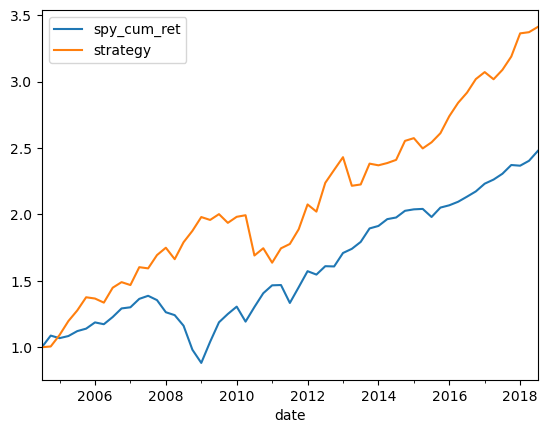

In [127]:
with open(
        r'/Users/zhihongqiu/Downloads/Simon-Chicago/CHICAGO/Machine Learning/L10/Lecture_1___Feb__8_____4_export/Data for HW 3/shap_features_ada.pkl',
        'rb') as f:
    shap_features = cPickle.load(f)
scalers = [StandardScaler() for i in range(len(start_dates) - 1)]

opt_training_data = [
    pd.DataFrame(scalers[i].fit_transform(training_frames[i][shap_features[i]].values), columns=shap_features[i]) for i
    in range(len(start_dates) - 1)]
opt_valid_data = [
    pd.DataFrame(scalers[i].fit_transform(training_frames[i][shap_features[i]].values), columns=shap_features[i]) for i
    in range(len(start_dates) - 1)]
opt_test_data = [pd.DataFrame(scalers[i].transform(test_frames[i][shap_features[i]].values), columns=shap_features[i])
                 for i in range(len(start_dates) - 1)]
x = [1]
ret = []

for i in range(len(start_dates) - 1):
    classifiers[i].fit(opt_training_data[i], training_labels[i])

    preds = classifiers[i].predict(opt_test_data[i])
    profit_i = (preds * test_frames[i]['next_period_return']).sum()
    ret.append(profit_i)
    num_names = len(opt_test_data[i])
    x.append(x[i] + (x[i] / num_names) * profit_i)
SPY = pd.read_pickle(r'/Users/zhihongqiu/Downloads/Simon-Chicago/CHICAGO/Machine Learning/L2/SPY_cum_ret.pkl')
SPY = SPY.loc['2004-09-01':'2018-09-30']
SPY = SPY.resample('Q').ffill()
SPY['spy_cum_ret'] = (SPY['spy_cum_ret'] - SPY['spy_cum_ret'][0] + 1)
SPY['strategy'] = x
SPY.plot();

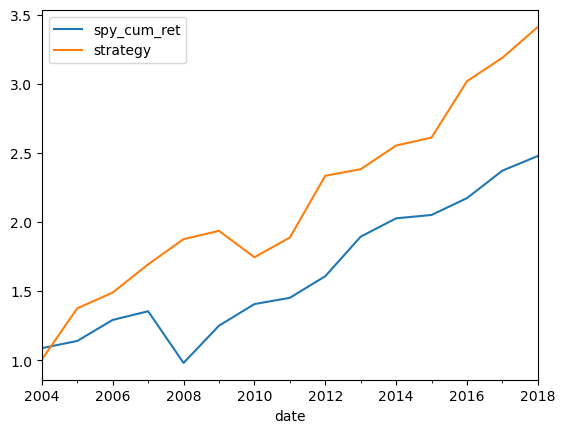

In [128]:
SPY = SPY.resample('Y').ffill()
SPY.plot();

Strategy Sharpe Ratio:  1.0453682586860649


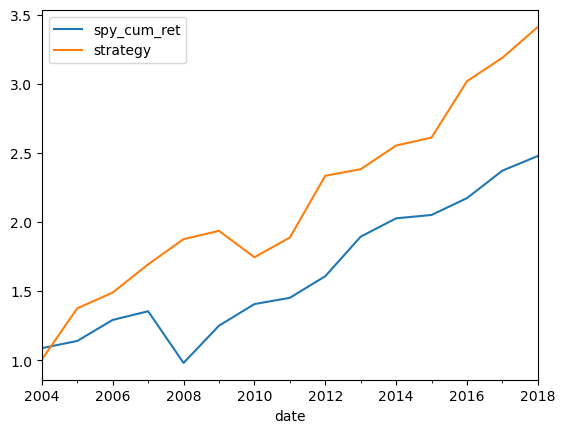

In [129]:
SPY.plot();
strategy_mean_ret = (SPY['strategy'] - 1).diff().mean()
strategy_std = (SPY['strategy'] - 1).diff().std()
strategy_sr = strategy_mean_ret / strategy_std
print('Strategy Sharpe Ratio: ', strategy_sr)

In [130]:
calculate_max_drawdown(SPY['strategy'])

-0.705274836862036

Second Feature

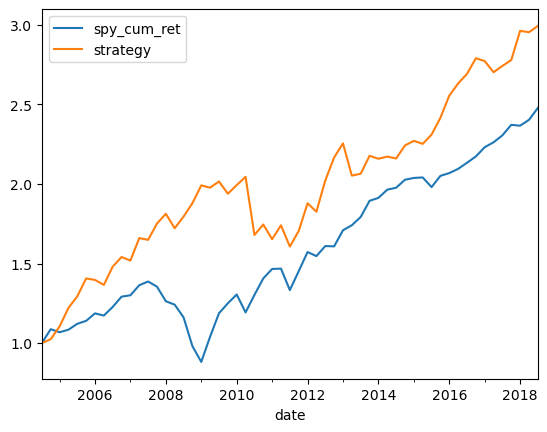

In [131]:
with open(
        r'/Users/zhihongqiu/Downloads/Simon-Chicago/CHICAGO/Machine Learning/L10/Lecture_1___Feb__8_____4_export/Data for HW 3/shap_features_ada_01.pkl',
        'rb') as f:
    shap_features = cPickle.load(f)
scalers = [StandardScaler() for i in range(len(start_dates) - 1)]

opt_training_data = [
    pd.DataFrame(scalers[i].fit_transform(training_frames[i][shap_features[i]].values), columns=shap_features[i]) for i
    in range(len(start_dates) - 1)]
opt_valid_data = [
    pd.DataFrame(scalers[i].fit_transform(training_frames[i][shap_features[i]].values), columns=shap_features[i]) for i
    in range(len(start_dates) - 1)]
opt_test_data = [pd.DataFrame(scalers[i].transform(test_frames[i][shap_features[i]].values), columns=shap_features[i])
                 for i in range(len(start_dates) - 1)]
x = [1]
ret = []

for i in range(len(start_dates) - 1):
    classifiers[i].fit(opt_training_data[i], training_labels[i])

    preds = classifiers[i].predict(opt_test_data[i])
    profit_i = (preds * test_frames[i]['next_period_return']).sum()
    ret.append(profit_i)
    num_names = len(opt_test_data[i])
    x.append(x[i] + (x[i] / num_names) * profit_i)
SPY = pd.read_pickle(r'/Users/zhihongqiu/Downloads/Simon-Chicago/CHICAGO/Machine Learning/L2/SPY_cum_ret.pkl')
SPY = SPY.loc['2004-09-01':'2018-09-30']
SPY = SPY.resample('Q').ffill()
SPY['spy_cum_ret'] = (SPY['spy_cum_ret'] - SPY['spy_cum_ret'][0] + 1)
SPY['strategy'] = x
SPY.plot();

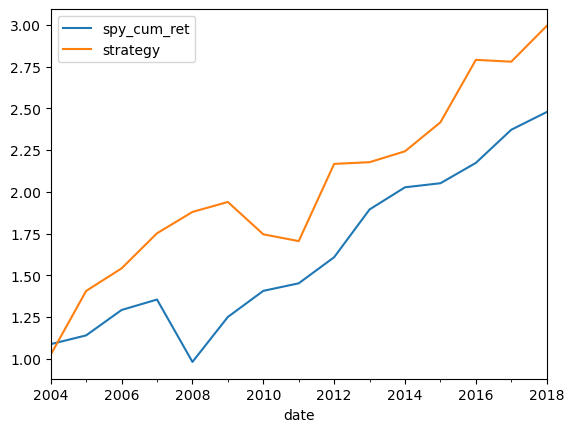

In [132]:
SPY = SPY.resample('Y').ffill()
SPY.plot();

Strategy Sharpe Ratio:  0.7780903628688984


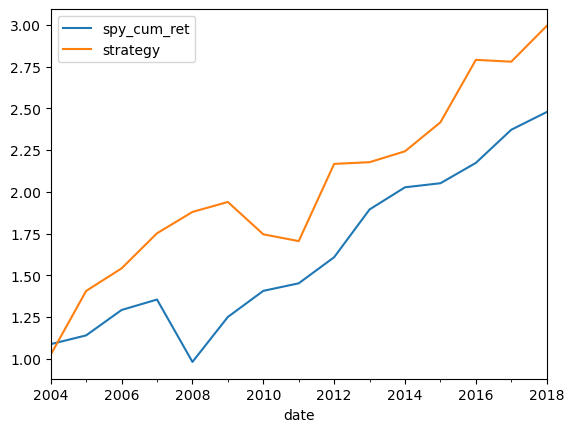

In [133]:
SPY.plot();
strategy_mean_ret = (SPY['strategy'] - 1).diff().mean()
strategy_std = (SPY['strategy'] - 1).diff().std()
strategy_sr = strategy_mean_ret / strategy_std
print('Strategy Sharpe Ratio: ', strategy_sr)

In [134]:
calculate_max_drawdown(SPY['strategy'])

-0.6578492359563801

Third Feature

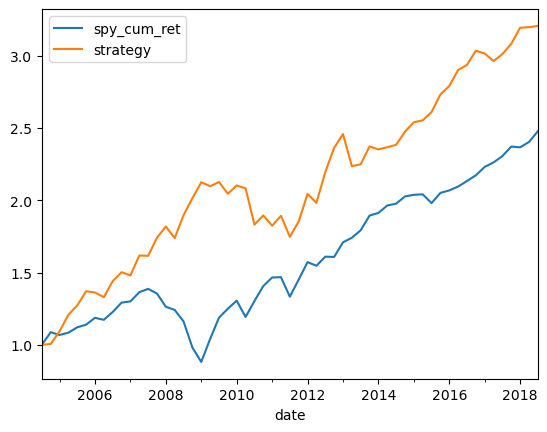

In [135]:
with open(
        r'/Users/zhihongqiu/Downloads/Simon-Chicago/CHICAGO/Machine Learning/L10/Lecture_1___Feb__8_____4_export/Data for HW 3/shap_features_ada_02.pkl',
        'rb') as f:
    shap_features = cPickle.load(f)
scalers = [StandardScaler() for i in range(len(start_dates) - 1)]

opt_training_data = [
    pd.DataFrame(scalers[i].fit_transform(training_frames[i][shap_features[i]].values), columns=shap_features[i]) for i
    in range(len(start_dates) - 1)]
opt_valid_data = [
    pd.DataFrame(scalers[i].fit_transform(training_frames[i][shap_features[i]].values), columns=shap_features[i]) for i
    in range(len(start_dates) - 1)]
opt_test_data = [pd.DataFrame(scalers[i].transform(test_frames[i][shap_features[i]].values), columns=shap_features[i])
                 for i in range(len(start_dates) - 1)]
x = [1]
ret = []

for i in range(len(start_dates) - 1):
    classifiers[i].fit(opt_training_data[i], training_labels[i])

    preds = classifiers[i].predict(opt_test_data[i])
    profit_i = (preds * test_frames[i]['next_period_return']).sum()
    ret.append(profit_i)
    num_names = len(opt_test_data[i])
    x.append(x[i] + (x[i] / num_names) * profit_i)
SPY = pd.read_pickle(r'/Users/zhihongqiu/Downloads/Simon-Chicago/CHICAGO/Machine Learning/L2/SPY_cum_ret.pkl')
SPY = SPY.loc['2004-09-01':'2018-09-30']
SPY = SPY.resample('Q').ffill()
SPY['spy_cum_ret'] = (SPY['spy_cum_ret'] - SPY['spy_cum_ret'][0] + 1)
SPY['strategy'] = x
SPY.plot();

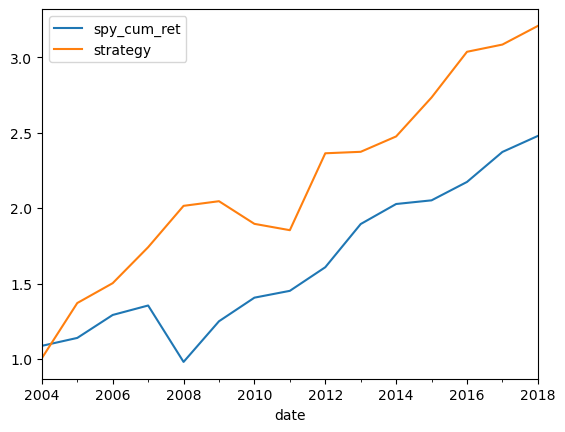

In [136]:
SPY = SPY.resample('Y').ffill()
SPY.plot();

Strategy Sharpe Ratio:  0.8879549878863978


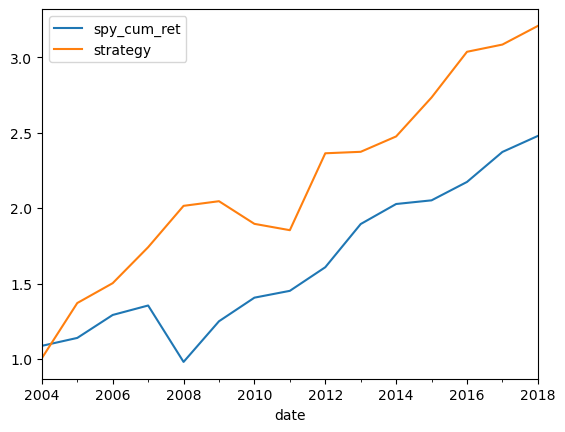

In [137]:
SPY.plot();
strategy_mean_ret = (SPY['strategy'] - 1).diff().mean()
strategy_std = (SPY['strategy'] - 1).diff().std()
strategy_sr = strategy_mean_ret / strategy_std
print('Strategy Sharpe Ratio: ', strategy_sr)

In [138]:
calculate_max_drawdown(SPY['strategy'])

-0.6864462775578356